# Imports

In [ ]:
# PyTprch and Transformers installation and import
# These are preinstalled so you will get "Requirement already satisfied" but nevertheless, it is required before you import the relevant packages.
# (not needed for the basic classificaiton models)

! pip install transformers datasets
! pip install torch

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [ ]:
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import nltk, scipy

In [ ]:
# personal install
!pip install torch torchvision

In [ ]:
# personal imports
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import re
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.metrics import make_scorer

# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Code and Helper Functions

### 1. Load data

In [ ]:
trump_train = '/content/trump_train.tsv'
trump_test = '/content/trump_tweets_test_a.tsv'

In [ ]:
def load_tweets_to_df(file_path):
    """
    Load tweets from a file into a pandas DataFrame.
    """

    feature_names = ['TweetID', 'UserHandle', 'TweetText', 'TimeStemp', 'Device']

    # Read the file line by line
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Parse the lines into a list of lists
    data = [line.strip().split('\t') for line in lines]

    # Create a DataFrame
    df = pd.DataFrame(data, columns=feature_names)

    return df

In [ ]:
def load_tweets_to_df_test(file_path):
    """
    Load tweets from a file into a pandas DataFrame.
    """

    feature_names = ['UserHandle', 'TweetText', 'TimeStemp']

    # Read the file line by line
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Parse the lines into a list of lists
    data = [line.strip().split('\t') for line in lines]

    # Create a DataFrame
    df = pd.DataFrame(data, columns=feature_names)

    return df

### 2. Preprocessing

In [ ]:
def time_features(df):
    df = df.copy()

    # Convert the 'TimeStemp' column to datetime
    df['TimeStemp'] = pd.to_datetime(df['TimeStemp'], errors='coerce')

    # Fill missing 'TimeStemp' values with a default value (e.g., January 1, 2000)
    default_time = pd.Timestamp('2000-01-01')
    df['TimeStemp'] = df['TimeStemp'].fillna(default_time)

    # Extract time-based features
    df['hour'] = df['TimeStemp'].dt.hour
    df['day'] = df['TimeStemp'].dt.weekday
    df['month'] = df['TimeStemp'].dt.month
    df['year'] = df['TimeStemp'].dt.year

    return df

In [ ]:
def text_features(df):
    df = df.copy()

    wordCount = []
    capitalCount = []
    hashtagsCount = []
    retweetCount = []
    exclamationCount = []
    urlCount = []
    pronounCount = []

    pronouns = r'\b(I|me|my|mine|myself|we|us|our|ours|ourselves|you|your|yours|yourself|yourselves|he|him|his|himself|she|her|hers|herself|it|its|itself|they|them|their|theirs|themselves)\b'

    for tweet in df['TweetText']:
        # Number of words
        wordCount.append(len(tweet.split()))

        # Number of capital letters
        capitalCount.append(sum(1 for c in tweet if c.isupper()))

        # Number of hashtags
        hashtagsCount.append(tweet.count('#'))

        # Check retweet
        retweetCount.append(tweet.count('@realDonaldTrump'))

        # Number of exclamation marks
        exclamationCount.append(tweet.count('!'))

        # Number of URLs
        urlCount.append(tweet.count('http'))

        # Number of pronouns
        pronounCount.append(len(re.findall(pronouns, tweet, re.IGNORECASE)))

    # Assign features to DataFrame
    df['wordCount'] = wordCount
    df['capitalLetters'] = capitalCount
    df['hashtags'] = hashtagsCount
    df['exclamationMarks'] = exclamationCount
    df['urlCount'] = urlCount
    df['retweet'] = retweetCount
    df['pronounCount'] = pronounCount

    return df

In [ ]:
def sentiment_features(df):
    df = df.copy()

    polarity = []
    subjectivity = []
    positive_words = []
    negative_words = []

    for tweet in df['TweetText']:
        # Sentiment analysis
        blob = TextBlob(tweet)
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)

        # Positive and negative words count
        words = tweet.split()
        pos_words = sum(1 for word in words if TextBlob(word).sentiment.polarity > 0)
        neg_words = sum(1 for word in words if TextBlob(word).sentiment.polarity < 0)
        positive_words.append(pos_words)
        negative_words.append(neg_words)

    df['polarity'] = polarity
    df['subjectivity'] = subjectivity
    df['positiveWords'] = positive_words
    df['negativeWords'] = negative_words

    return df

In [ ]:
def emotion_features(df):
    df = df.copy()

    # Load the emotion detection model
    emotion_classifier = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base', return_all_scores=True)

    emotions = {emotion: [] for emotion in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']}

    for tweet in df['TweetText']:
      # Emotion analysis
      emotion_scores = emotion_classifier(tweet)[0]
      emotion_dict = {score['label']: score['score'] for score in emotion_scores}
      for emotion in emotions:
          emotions[emotion].append(emotion_dict.get(emotion, 0))

    for emotion in emotions:
        df[emotion] = emotions[emotion]

    # Display the DataFrame with the new features
    return df

In [ ]:
def create_target_and_clean_df(df, cols_to_drop):
  df= df.copy()

  # Filter the DataFrame
  df_filtered = df[(df['UserHandle'] == 'realDonaldTrump') & (df['Device'].isin(['iphone', 'android']))].copy()

  # Create the "NotTrump" column => Target col
  df_filtered['NotTrump'] = df_filtered['Device'].apply(lambda x: 1 if x == 'iphone' else 0)

  # Drop the specified columns
  df_filtered.drop(columns=cols_to_drop, inplace=True)

  return df_filtered

In [ ]:
def clean_text(text):
  # stop_words = set(stopwords.words('english'))
  # Remove punctuation
  # text = re.sub(r'[^\w\s]', '', text)
  # Remove stop words and convert to lower case
  # text = ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
  return text

In [ ]:
def balancingTrainSet(train):
    """
    Balances the train set by undersampling the majority class.
    """

    # Separate classes
    trumpTweets = train[train['NotTrump'] == 0]
    stafferTweets = train[train['NotTrump'] == 1]

    # Get the count of the minority class
    stafferTweetsCount = len(stafferTweets)

    # Sample from the majority class to match the minority class count
    sampledTrumpTweets = trumpTweets.sample(n=stafferTweetsCount, random_state=26)

    # Combine both classes to create a balanced dataset
    balancedTrain = pd.concat([stafferTweets, sampledTrumpTweets])

    # Reset index to clean up the DataFrame
    balancedTrain = balancedTrain.reset_index(drop=True)

    return balancedTrain

In [ ]:
def preprocess_data(df, target_column='NotTrump'):

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    return X, y

### 3. Models

#### 1. LR + SVM + XGBoost (1 + 2 + 4)

In [ ]:
def train_model_with_best_params(model_name, best_params, X, y, scaler=None, n_splits=5):
    model = None

    if model_name == "Logistic Regression":
        model = LogisticRegression(**best_params)
    elif model_name == "SVM with Linear Kernel":
        model = SVC(kernel='linear', probability=True, **best_params)
    elif model_name == "XGBoost":
        model = XGBClassifier(eval_metric='logloss', **best_params)

    model.fit(X, y)

    return model

In [ ]:
def train_all_models_with_best_params(alg, balanced_df):
    # Preprocess the data
    X, y = preprocess_data(balanced_df)

    # Define the best parameters found from grid search
    best_params = {
        "Logistic Regression": {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'},
        "SVM with Linear Kernel": {'C': 10},
        "XGBoost": {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
    }

    if alg == 1:
      return train_model_with_best_params("Logistic Regression", best_params["Logistic Regression"], X, y, scaler=None, n_splits=5)

    if alg == 2:
      return train_model_with_best_params("SVM with Linear Kernel", best_params["SVM with Linear Kernel"], X, y, scaler=None, n_splits=5)

    if alg == 4:
      return train_model_with_best_params("XGBoost", best_params["XGBoost"], X, y, scaler=None, n_splits=5)

In [ ]:
def predict_with_custom_threshold(model, X):
    best_thresholds = {
        LogisticRegression: 0.5,
        SVC: 0.55,
        XGBClassifier: 0.5,
    }

    # Determine the model type
    model_type = type(model)
    threshold = best_thresholds.get(model_type, 0.5)  # Default to 0.5 if not found

    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(X)[:, 1]
    else:
        probabilities = model.decision_function(X)
        probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())  # Scaling to [0,1]

    # Apply custom threshold
    predictions = (probabilities >= threshold).astype(int)

    return predictions

#### 2. FFNN Model (3)

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
def train_model_from_df(df, target_column='NotTrump', batch_size=32, num_epochs=100, learning_rate=0.001, patience=10, threshold=0.55):
    # Prepare the data
    X = df.drop(target_column, axis=1).values
    y = df[target_column].values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

    # Create Tensor datasets for DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # DataLoader setup
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize the model
    model = FFNN(input_dim=X.shape[1])

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Track best validation loss for early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training loop with early stopping
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loss and predictions
        model.eval()
        val_loss = 0
        predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted_classes = (outputs > threshold).float()  # Apply threshold
                predictions.append(predicted_classes)

        val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                # print(f'Stopping early at epoch {epoch+1}')
                break

    # Return the trained model
    return model


In [ ]:
def predict_with_model(model, df, batch_size=32, threshold=0.45):
    # Assume that the model and df are properly formatted and the model is already trained

    # Prepare the data
    X = df.values

    # Ideally, you should use the same scaler that was fit on the training data
    # Here we assume the scaler is re-used or fit previously; adjust accordingly if needed
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Fit on training data, transform on test data

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    # Create Tensor dataset for DataLoader
    test_dataset = TensorDataset(X_tensor)

    # DataLoader setup for test data
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Prediction
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, in test_loader:  # Notice we only take inputs since there are no labels
            outputs = model(inputs)
            predicted_classes = (outputs > threshold).int()  # Apply threshold
            predictions.append(predicted_classes)

    # Convert predictions to a space-separated string of integers
    predictions = torch.cat(predictions).reshape(-1).numpy()
    result_string = ' '.join(map(str, predictions.astype(int)))

    return predictions

#### 3. DistilBERT (5)


In [ ]:
class TweetDataset(Dataset):
    def __init__(self, data, tokenizer, text_col, label_col=None):
        self.data = data
        self.texts = data[text_col].values
        self.labels = data[label_col].values if label_col is not None else None
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        item = {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten()
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [ ]:
def train_model_DistilBERT(train_data, text_col, label_col, epochs=4, batch_size=16, learning_rate=2e-5):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    train_dataset = TweetDataset(train_data, tokenizer, text_col, label_col)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    num_labels = len(train_data[label_col].unique())
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    return model

In [ ]:
def predict_model_DistilBERT(model, test_data, text_col, batch_size=16, threshold=0.45):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    test_dataset = TweetDataset(test_data, tokenizer, text_col)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = (probs[:, 1] > threshold).int()  # Assuming binary classification

            predictions.append(preds)

    predictions = torch.cat(predictions).cpu().numpy()
    return predictions

# Assignment Functions

**Algorithmic approaches:**



1. [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
2. [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (try both linear and nonlinear kernels!)
3. FFNN classifier - You should use  the PyTorch library to build a FFNN classifier (with at least one hidden layer) to achieve the classification. Feel free to experiment with the number of layers ([a simple tutorial for FFNN with PyTorch](https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb)).
4. A fourth classifier of choice (neural or not). You are encouraged to experiment with classifiers that allow combining different types of features (e.g. number of capitalized words, time of tweeting, etc.)
5. A fifth classifier of your choice  (this should be neural -  RNN, or transformer-based) - feel free to experiment.



Your notebook should support the following functions:

In [ ]:
def training_pipeline(alg, train_fn = "trump_train.csv"):
  """Returns a trained model given the specific task and algorithm.
      The pipeline should include all necessary steps that are needed for the
      specified algoritm (preprocessing, normalization, feature extraction - depending
      on your choice and decisions). Obviously, it is advised to implement the pipeline
      through a sequence of function calls.

    Args:

        alg (int): an integer between 1-5, indicating the algorithmic approach as
                    specified above (1: logistic regression, 2: svm, 3:FFNN, etc.).
        train_ fn (str): full path to the file containing the training data.

  """

  # load the df from given path
  df = load_tweets_to_df(trump_train)

  # Preprocess the data
  if alg == 5:
    # use glove embbeding for the LSTMmodel
    df['CleanTweetText'] = df['TweetText'].apply(clean_text)
    df = create_target_and_clean_df(df, ['UserHandle', 'Device', 'TweetID', 'TimeStemp', 'TweetText'])
    df = balancingTrainSet(df)
    return train_model_DistilBERT(df, 'CleanTweetText', 'NotTrump')


  # For all other algorithms use feature-based classification
  df = time_features(df)
  df = text_features(df)
  df = sentiment_features(df)
  df = emotion_features(df)
  df = create_target_and_clean_df(df, ['UserHandle', 'Device', 'TweetID', 'TimeStemp', 'TweetText'])
  df = balancingTrainSet(df)

  # fit mode
  if alg == 1:
    return train_all_models_with_best_params(1, df)
  if alg == 2:
    return train_all_models_with_best_params(2, df)
  if alg == 3:
    return train_model_from_df(df)
  if alg == 4:
    return train_all_models_with_best_params(4, df)

  raise ValueError("Invalid algorithm number. Must be between 1 and 5.")

  return None

In [ ]:
def retrain_best_model(train_fn = "trump_train.csv"):
  """ Retrains and returns the best performing model for the specified task. The
      function uses the hard coded settings you have found to work best for each
      of the tasks.

      Args:
        rain_ fn (str): full path to the file containing the training data.

  """
  m = training_pipeline(5, train_fn)

  return m

In [ ]:
def predict(m, fn = "trump_tweets_test_a.tsv"):
  """ Returns a list of 0s and 1s, corresponding to the lines in the specified file.

    Args:
      m: the trained model to be used.
      fn: the full path to a file in the same format as the test set we have proveded.
      SoT = scaler or tokenizer depending on the type of model
  """

  df_test = load_tweets_to_df_test(fn)

  if isinstance(m, DistilBertForSequenceClassification): # DistilBERT
    df_test['CleanTweetText'] = df_test['TweetText'].apply(clean_text)
    return predict_model_DistilBERT(m, df_test, 'CleanTweetText')

  df_test = time_features(df_test)
  df_test = text_features(df_test)
  df_test = sentiment_features(df_test)
  df_test = emotion_features(df_test)
  df_test.drop(columns=['UserHandle', 'TweetText', 'TimeStemp'], inplace= True)

  # Check if the model is an instance of FFNN
  if isinstance(m, FFNN):
      return predict_with_model(m, df_test)

  else: # models 1-LG or 2-SVM or 4-XGBOOST
    try:
      return predict_with_custom_threshold(m, df_test)
    except:
      raise ValueError("Invalid Model Type.")




  # return res #a list containing the predictions

In [ ]:
def who_am_i():  # this is not a class method
    """Returns a ductionary with your name, id number and email. keys=['name', 'id','email']
        Make sure you return your own info!
    """
    return {'name': 'Yuval Sabag, Shani Bahat', 'id': '206750002, 206678872', 'email': 'yuvsa@post.bgu.ac.il, shanibah@post.bgu.ac.il'}

# **EDA & CROSS VALIDATION RESULTS - LONG RUN TIME DO NOT RUN**


#### **Exploratory Data Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3528 entries, 0 to 3527
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TweetID     3528 non-null   object
 1   UserHandle  3528 non-null   object
 2   TweetText   3528 non-null   object
 3   TimeStemp   3528 non-null   object
 4   Device      3528 non-null   object
dtypes: object(5)
memory usage: 137.9+ KB


In [ ]:
df['Device'].value_counts()

Device
android                  2255
iphone                    997
webClient                 240
BlackBerry</a>             12
tweetDeck                   8
instagram                   6
iPad</a>                    6
otherPeriscope.TV</a>       3
otherFacebook</a>           1
Name: count, dtype: int64

In [ ]:
df['UserHandle'].value_counts()

UserHandle
realDonaldTrump    3515
PressSec             12
POTUS                 1
Name: count, dtype: int64

In [ ]:
# tweets words len
df['TweetText'].str.split().apply(len).describe()

count    3528.000000
mean       17.758220
std         6.638777
min         1.000000
25%        13.000000
50%        19.000000
75%        23.000000
max        31.000000
Name: TweetText, dtype: float64

In [ ]:
# find the tweet with the maximum number of words
df.loc[df['TweetText'].str.split().apply(len).idxmax()]

TweetID                                      617108111703322624
UserHandle                                      realDonaldTrump
TweetText     @marcorubio what do you say to the family of K...
TimeStemp                                      otherTwitter for
Device                                           BlackBerry</a>
Name: 989, dtype: object

##### **1. Distribution of Tweet Word Count by Device Type**

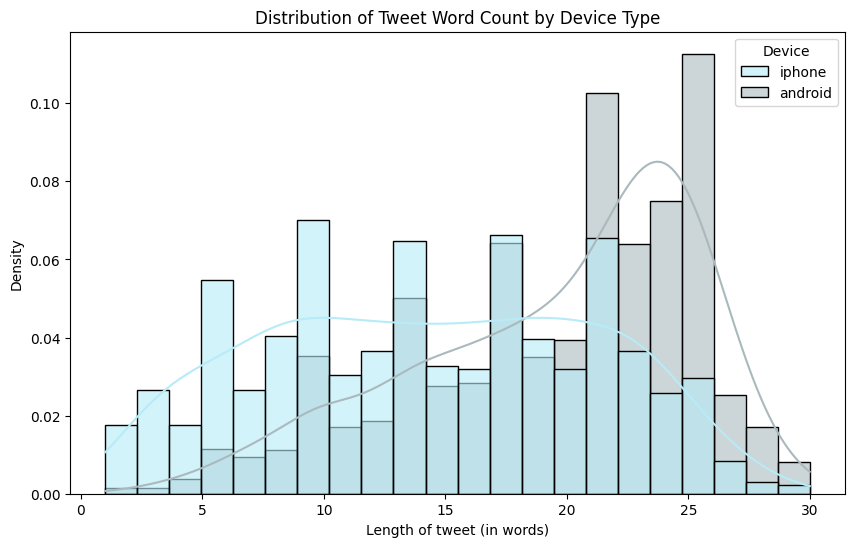

In [ ]:
# Filter to include only iPhone and Android tweets
filtered_tweets = df[df['Device'].isin(['iphone', 'android'])].copy()

# Calculate word count for each tweet
filtered_tweets['word_count'] = filtered_tweets['TweetText'].apply(lambda x: len(x.split()))

# Plotting with histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_tweets, x='word_count', hue='Device', kde=True, element='bars', stat='density', common_norm=False, palette=['#b7ebf7', '#aab9bd'], alpha=0.6)
plt.title('Distribution of Tweet Word Count by Device Type')
plt.xlabel('Length of tweet (in words)')
plt.ylabel('Density')
plt.show()

##### **2. Label Frequency by Device Type**

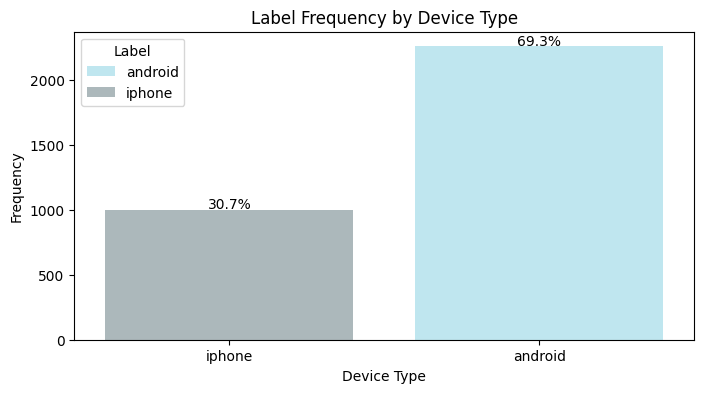

In [ ]:
# Filter to include only iPhone and Android tweets
filtered_tweets = df[df['Device'].isin(['iphone', 'android'])].copy()

# Map device types to labels (assuming 'android' = Trump (0) and 'iphone' = staffers (1))
filtered_tweets.loc[:, 'label'] = filtered_tweets['Device'].map({'android': 0, 'iphone': 1})

# Create the plot
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Device', hue='label', data=filtered_tweets, palette=['#b7ebf7', '#aab9bd'])

# Title and labels
plt.title('Label Frequency by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Frequency')

# Calculate percentages and annotate bars
total = len(filtered_tweets)
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if there are entries for the bar
        percentage = f'{100 * height / total:.1f}%'  # calculate percentage
        ax.text(p.get_x() + p.get_width() / 2., height + 10, percentage, ha="center")

plt.legend(title='Label', labels=['android', 'iphone'])
plt.show()

##### **3. Time Series Analysis**
Plotting tweet frequencies over time could reveal patterns in usage—perhaps Trump tweets more frequently at certain times, or there's a noticeable shift in device usage during specific periods.

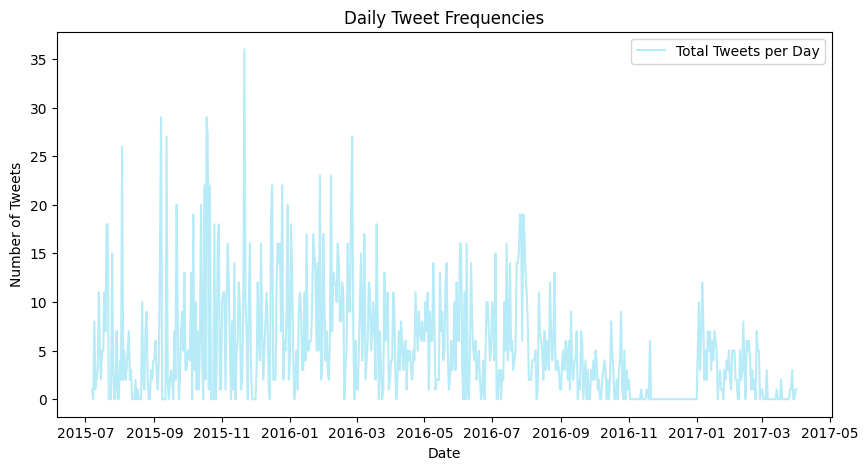

In [ ]:
# Convert 'Timestamp' to datetime
filtered_tweets['TimeStemp'] = pd.to_datetime(filtered_tweets['TimeStemp'])

# Resample to a suitable frequency, e.g., daily
daily_tweets = filtered_tweets.set_index('TimeStemp').resample('D').count()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(daily_tweets.index, daily_tweets['TweetID'], label='Total Tweets per Day', color='#b7ebf7')
plt.title('Daily Tweet Frequencies')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()

### **Modeling - Cross Validation Results**

#### **LR ,SVM, XGBoost**

In [ ]:
def preprocess_data(df, target_column='NotTrump'):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return X, y

In [ ]:
def custom_f1_score(y_true, y_pred_prob, threshold):
    y_pred_custom = (y_pred_prob >= threshold).astype(int)
    return f1_score(y_true, y_pred_custom)

In [ ]:
def custom_scorer(threshold):
    return make_scorer(custom_f1_score, greater_is_better=True, needs_proba=True, threshold=threshold)

In [ ]:
def train_and_evaluate_model_with_grid_search(model, param_grid, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=26)

    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    accuracy_scores = []

    best_threshold = None
    best_f1 = 0

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search = GridSearchCV(model, param_grid, cv=3, scoring=make_scorer(recall_score), n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        # Find the best threshold
        y_pred_prob = best_model.predict_proba(X_test)[:, 1]
        thresholds = np.arange(0.4, 0.6, 0.05)
        for threshold in thresholds:
            f1 = custom_f1_score(y_test, y_pred_prob, threshold)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Apply the best threshold to evaluate the model
        y_pred_custom = (y_pred_prob >= best_threshold).astype(int)
        precision_scores.append(precision_score(y_test, y_pred_custom))
        recall_scores.append(recall_score(y_test, y_pred_custom))
        f1_scores.append(f1_score(y_test, y_pred_custom))
        auc_scores.append(roc_auc_score(y_test, y_pred_prob))
        accuracy_scores.append(accuracy_score(y_test, y_pred_custom))

    avg_metrics = {
        "accuracy": np.mean(accuracy_scores),
        "precision": np.mean(precision_scores),
        "recall": np.mean(recall_scores),
        "f1": np.mean(f1_scores),
        "auc": np.mean(auc_scores)
    }

    return avg_metrics, grid_search.best_params_, best_threshold

In [ ]:
# Preprocess the data
X, y = preprocess_data(balanced_df)

# Define models and their respective parameter grids
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM with Linear Kernel": SVC(kernel='linear', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
    },
    "SVM with Linear Kernel": {
        'C': [0.01, 0.1, 1, 10],
    },
    "XGBoost": {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'gamma': [0, 0.1],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
    }
}

In [ ]:
# Train and evaluate each model using Grid Search
results = {}
best_params = {}
best_thresholds = {}
for model_name, model in models.items():
    metrics, best_params[model_name], best_thresholds[model_name] = train_and_evaluate_model_with_grid_search(
        model, param_grids[model_name], X, y, n_splits=5
    )
    results[model_name] = metrics

# Print best parameters, thresholds, and results for each model
for model_name in models.keys():
    print(f"\n### {model_name} ###")
    print(f"Best parameters: {best_params[model_name]}")
    print(f"Best threshold: {best_thresholds[model_name]}")
    for metric, value in results[model_name].items():
        print(f'Average {metric.capitalize()}: {value:.3f}')

#### **FFNN**

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
# Function to train the FFNN model
def train_ffnn(model, criterion, optimizer, train_loader, val_loader, device, epochs=100, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device).unsqueeze(1)
            optimizer.zero_grad()
            output = model(data)  # Forward pass
            loss = criterion(output, target.float())  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()

        # Validation loss
        model.eval()
        val_losses = []
        with torch.no_grad():  # No gradient computation
            for data, target in val_loader:
                data, target = data.to(device), target.to(device).unsqueeze(1)
                output = model(data)  # Forward pass
                val_loss = criterion(output, target.float())
                val_losses.append(val_loss.item())

        average_val_loss = sum(val_losses) / len(val_losses)
        # print(f'Epoch {epoch}, Validation Loss: {average_val_loss}')

        # Check for early stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            torch.save(model.state_dict(), './best_ffnn_enhanced.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # print("Early stopping")
                break

In [ ]:
# Function to evaluate the FFNN model
def evaluate_ffnn(model, criterion, test_loader, device):
    model.eval()
    y_pred_prob = []
    y_true = []
    with torch.no_grad():  # No gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model(data)  # Forward pass
            y_pred_prob.extend(output.cpu().numpy().flatten())  # Collect predictions
            y_true.extend(target.cpu().numpy().flatten())  # Collect true labels
    return np.array(y_pred_prob), np.array(y_true)

In [ ]:
# Preprocess the data
X, y = preprocess_data(balanced_df)

def train_and_evaluate_ffnn_pytorch(X, y, thresholds, n_splits=10, device='cpu', epochs=100, patience=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=26)

    best_threshold = None
    best_f1 = 0

    for threshold in thresholds:
        precision_scores = []
        recall_scores = []
        f1_scores = []
        auc_scores = []
        accuracy_scores = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Scale the data
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Convert to PyTorch tensors
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

            # Define the FFNN model
            input_dim = X_train.shape[1]
            model = FFNN(input_dim).to(device)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Train the FFNN model with early stopping
            train_ffnn(model, criterion, optimizer, train_loader, test_loader, device, epochs=epochs, patience=patience)

            # Load the best model
            model.load_state_dict(torch.load('./best_ffnn_enhanced.pth'))
            model.eval()

            # Evaluate the FFNN model
            y_pred_prob, y_true = evaluate_ffnn(model, criterion, test_loader, device)

            # Apply custom threshold
            y_pred_custom = (y_pred_prob >= threshold).astype(int)

            # Evaluate the model
            precision_scores.append(precision_score(y_true, y_pred_custom))
            recall_scores.append(recall_score(y_true, y_pred_custom))
            f1_scores.append(f1_score(y_true, y_pred_custom))
            auc_scores.append(roc_auc_score(y_true, y_pred_prob))
            accuracy_scores.append(accuracy_score(y_true, y_pred_custom))

        avg_f1 = np.mean(f1_scores)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_threshold = threshold

    print(f"Best threshold: {best_threshold} with F1 score: {best_f1:.3f}")

    # Final evaluation with best threshold
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    accuracy_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scale the data
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Define the FFNN model
        input_dim = X_train.shape[1]
        model = FFNN(input_dim).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the FFNN model with early stopping
        train_ffnn(model, criterion, optimizer, train_loader, test_loader, device, epochs=epochs, patience=patience)

        # Load the best model
        model.load_state_dict(torch.load('./best_ffnn_enhanced.pth'))
        model.eval()

        # Evaluate the FFNN model
        y_pred_prob, y_true = evaluate_ffnn(model, criterion, test_loader, device)

        # Apply custom threshold
        y_pred_custom = (y_pred_prob >= best_threshold).astype(int)
        print(y_pred_custom)

        # Evaluate the model
        precision_scores.append(precision_score(y_true, y_pred_custom))
        recall_scores.append(recall_score(y_true, y_pred_custom))
        f1_scores.append(f1_score(y_true, y_pred_custom))
        auc_scores.append(roc_auc_score(y_true, y_pred_prob))
        accuracy_scores.append(accuracy_score(y_true, y_pred_custom))

    avg_metrics = {
        "accuracy": np.mean(accuracy_scores),
        "precision": np.mean(precision_scores),
        "recall": np.mean(recall_scores),
        "f1": np.mean(f1_scores),
        "auc": np.mean(auc_scores)
    }

    for metric, value in avg_metrics.items():
        print(f'Average {metric.capitalize()}: {value:.3f}')

    return avg_metrics

In [ ]:
# Define FFNN thresholds
ffnn_thresholds = [0.45, 0.5, 0.55]

# Train and evaluate FFNN model with cross-validation and custom threshold tuning using PyTorch
ffnn_pytorch_results = train_and_evaluate_ffnn_pytorch(X, y, ffnn_thresholds, device='cuda' if torch.cuda.is_available() else 'cpu', epochs=100, patience=10)

#### **DistilBERT**

In [ ]:
# Assuming your DataFrame is named df
data = df

# Verify columns exist
assert 'CleanTweetText' in data.columns, "Column 'CleanTweetText' not found in DataFrame"
assert 'NotTrump' in data.columns, "Column 'NotTrump' not found in DataFrame"

# Split data into train and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Preprocess data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.texts = data['CleanTweetText'].values
        self.labels = data['NotTrump'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset and dataloader
train_dataset = TweetDataset(train_data)
test_dataset = TweetDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
num_labels = len(data['NotTrump'].unique())
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(3):
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = torch.tensor(all_probs)  # Ensure all_probs is a 2D array
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
avg_auc = roc_auc_score(all_labels, all_probs[:, 1], multi_class='ovr')
avg_accuracy = accuracy_score(all_labels, all_preds)

print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')
print(f'Average AUC: {avg_auc}')
print(f'Average Accuracy: {avg_accuracy}')


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score

# Assuming your DataFrame is named df
data = df

# Verify columns exist
assert 'CleanTweetText' in data.columns, "Column 'CleanTweetText' not found in DataFrame"
assert 'NotTrump' in data.columns, "Column 'NotTrump' not found in DataFrame"

# Split data into train and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Preprocess data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.texts = data['CleanTweetText'].values
        self.labels = data['NotTrump'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset and dataloader
train_dataset = TweetDataset(train_data)
test_dataset = TweetDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
num_labels = len(data['NotTrump'].unique())
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(4):
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = torch.tensor(all_probs)  # Ensure all_probs is a 2D array
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
avg_auc = roc_auc_score(all_labels, all_probs[:, 1], multi_class='ovr')
avg_accuracy = accuracy_score(all_labels, all_preds)

print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')
print(f'Average AUC: {avg_auc}')
print(f'Average Accuracy: {avg_accuracy}')

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score

# Assuming your DataFrame is named df
data = df

# Verify columns exist
assert 'CleanTweetText' in data.columns, "Column 'CleanTweetText' not found in DataFrame"
assert 'NotTrump' in data.columns, "Column 'NotTrump' not found in DataFrame"

# Split data into train and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Preprocess data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.texts = data['CleanTweetText'].values
        self.labels = data['NotTrump'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset and dataloader
train_dataset = TweetDataset(train_data)
test_dataset = TweetDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
num_labels = len(data['NotTrump'].unique())
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(5):
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = torch.tensor(all_probs)  # Ensure all_probs is a 2D array
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
avg_auc = roc_auc_score(all_labels, all_probs[:, 1], multi_class='ovr')
avg_accuracy = accuracy_score(all_labels, all_preds)

print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')
print(f'Average AUC: {avg_auc}')
print(f'Average Accuracy: {avg_accuracy}')

### **Test Homework Functions**

In [ ]:
### Test Homework Functions
for i in range (1, 6):
  print(f"Model {i}")
  m = training_pipeline(i)
  res =predict(m)
  print(f"Number of predictions: {len(res)}")
  print(f"Predictions: {res}")
  print('####################')